# **Biomes & Objects Recognition using Satellite images**

## Enable Google Colab

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import libraries

In [0]:
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import time, pickle, pandas

%matplotlib inline
%tensorflow_version 1.x

In [0]:
import tensorflow
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout
from tensorflow.python.keras.applications import ResNet152

from sklearn.model_selection import StratifiedKFold

## Import UCMerced LandUse dataset

In [0]:
# Upload dataset to ggdrive in a zip file (by hand), and unzip it

!unzip "/content/drive/My Drive/Colab Notebooks/COMS4995_Final_Project/UCMerced_LandUse.zip"

## Pre-process data

In [0]:
# Data parameters

img_width, img_height = 256, 256
num_classes = 21
nb_samples_per_class = 100

In [0]:
class_name = {
    0: 'agricultural',
    1: 'airplane',
    2: 'baseballdiamond',
    3: 'beach',
    4: 'buildings',
    5: 'chaparral',
    6: 'denseresidential',
    7: 'forest',
    8: 'freeway',
    9: 'golfcourse',
    10: 'harbor',
    11: 'intersection',
    12: 'mediumresidential',
    13: 'mobilehomepark',
    14: 'overpass',
    15: 'parkinglot',
    16: 'river',
    17: 'runway',
    18: 'sparseresidential',
    19: 'storagetanks',
    20: 'tenniscourt'
}

In [0]:
# Import images and labels

X = []
Y = []

for k in range(num_classes):
  X.append([np.array(Image.open(im).resize((img_width, img_height))) 
            for im in glob.glob('/content/UCMerced_LandUse/Images/' + class_name[k] + '/*.tif')])
  Y.append([np.ones(nb_samples_per_class) * k])
  
X = np.array(X).reshape(-1, img_width, img_height, 3)
Y = np.array(Y).reshape(-1)

In [0]:
# Utility function to show samples

def show_sample(X, y, prediction = -1):
    im = X
    plt.imshow(im)
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (class_name[y], class_name[prediction]))
    else:
        plt.title("Class = %s" % (class_name[y]))

    plt.axis('on')
    plt.show()

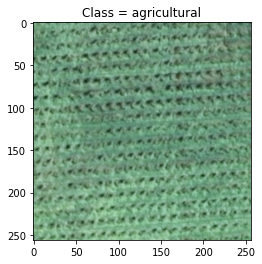

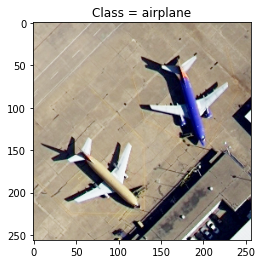

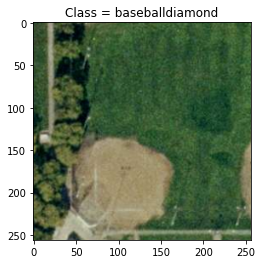

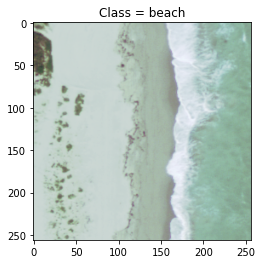

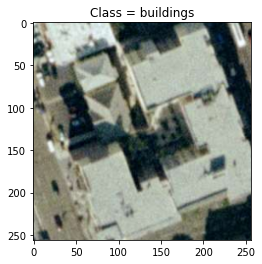

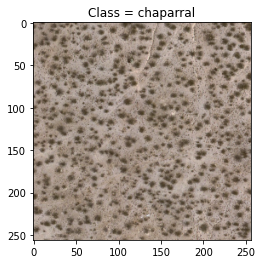

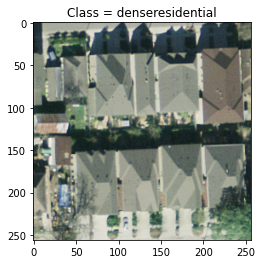

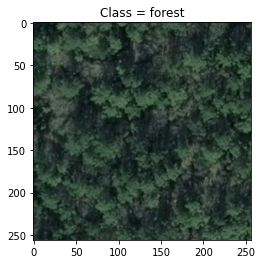

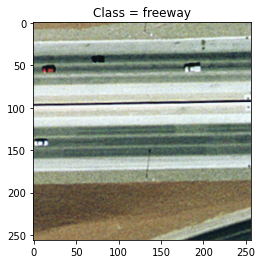

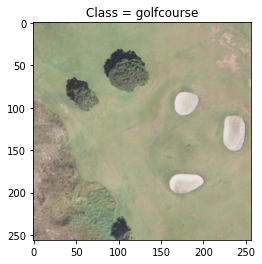

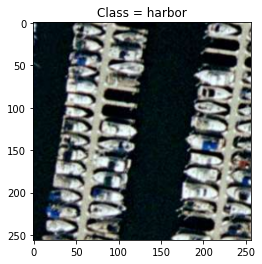

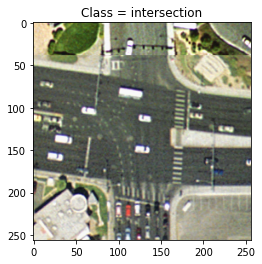

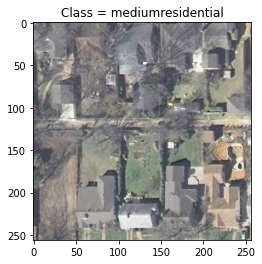

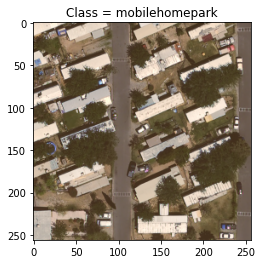

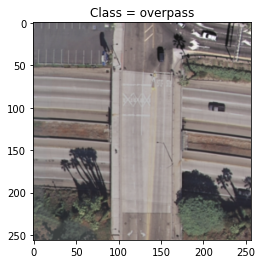

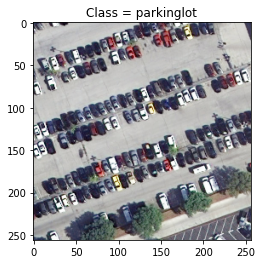

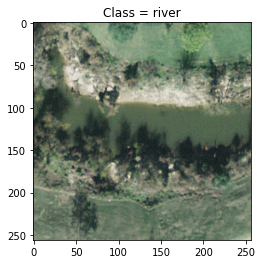

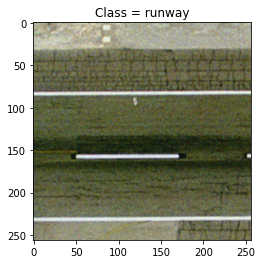

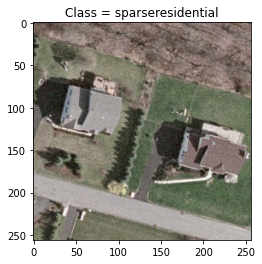

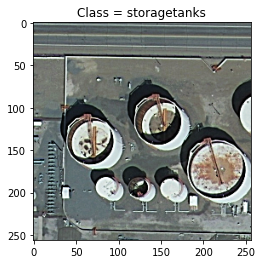

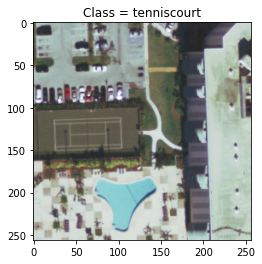

In [53]:
# Show 1 image of each class 

l = np.random.randint(0, nb_samples_per_class)
for i in range(num_classes):
  show_sample(X[i*nb_samples_per_class + l], Y[i*nb_samples_per_class + l])

## First model : hand-crafted

In [0]:
def create_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape = (img_width, img_height, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))

  return model

In [0]:
# Training parameters

epochs = 3
batch_size = 20

In [0]:
# I had several GPU memory usage problems. This function helped me a lot (taken from github)

from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    #print(gc.collect()) # if it's done something you should see a number being outputted
    gc.collect()

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

Using TensorFlow backend.


In [0]:
# Train our hand-crafted model. Since we don't have a lot of samples (only 100 per class),
# we use k-fold Cross Validation to see if the network can generalize well.

kfold = StratifiedKFold(n_splits = 5, shuffle = True)
CV_scores = []

for train, test in kfold.split(X, Y):
  tensorflow.keras.backend.clear_session()
  tensorflow.reset_default_graph()

  model = create_model()

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
  model.fit(X[train], Y[train], epochs = epochs, batch_size = batch_size, verbose = 1,
            validation_data = (X[test], Y[test]))
  loss, accuracy = model.evaluate(X[test], Y[test], verbose = 0)
  print("Training. Accuracy : {} %. Loss : {}".format(accuracy * 100, loss))
  
  CV_scores.append(accuracy * 100)
 
  for _ in range(10):
    reset_keras() # allows to free GPU memory between run

print("Average accuracy : %.2f%% (+/- %.2f%%)" % (np.mean(CV_scores), np.std(CV_scores)))

Train on 1680 samples, validate on 420 samples
Epoch 1/3
1680/1680 [==============================] - 17s 10ms/sample - loss: 48.1263 - sparse_categorical_accuracy: 0.0595 - val_loss: 3.0391 - val_sparse_categorical_accuracy: 0.0571
Epoch 2/3
1680/1680 [==============================] - 17s 10ms/sample - loss: 3.0003 - sparse_categorical_accuracy: 0.0958 - val_loss: 2.9450 - val_sparse_categorical_accuracy: 0.0786
Epoch 3/3
1680/1680 [==============================] - 17s 10ms/sample - loss: 2.9470 - sparse_categorical_accuracy: 0.0869 - val_loss: 3.0676 - val_sparse_categorical_accuracy: 0.0500
Training. Accuracy : 5.000000074505806 %. Loss : 3.0675958678835915
Train on 1680 samples, validate on 420 samples
Epoch 1/3
1680/1680 [==============================] - 17s 10ms/sample - loss: 82.4785 - sparse_categorical_accuracy: 0.0512 - val_loss: 3.0189 - val_sparse_categorical_accuracy: 0.0524
Epoch 2/3
1680/1680 [==============================] - 17s 10ms/sample - loss: 2.8633 - sparse_c

The accuracy is really horrible ! Guessing a class randomly leads to an accuracy of 100/21 = 4.76. So we only do a little bit better than guessing at random with this model.

Hence, we need a much more powerful one.

## Second model : Resnet

Since we have very few data and previous example showed that a small network performs very poorly, we will have to use Transfer Learning.

I tried with multiple pre-trained networks, and Resnet was the one giving the best results. Hence, this is the one I will show in this report. I also tried many hyperparameters, but I will only present the most relevant ones (i.e. leading to the best results). Moreovers, I will present the results of the model using different gradient descents, as the difference in results is noticeable and interesting to study.

In [0]:
# Training parameters 
# (I tried with longer epochs, but the accuracy wasn't improved --> 2 epochs are sufficient here)

resnet_weights_path = 'imagenet' # use Resnet pre-trained on ImageNet

epochs_top = 2 # epochs for training the fresh new top of the network
epochs_full = 2 # epochs for fine-tuning the whole network once the top is trained
batch_size_top = 20
batch_size_full = 20

In [0]:
# Our new model : Resnet and a small top

model = Sequential()
model.add(ResNet152(include_top = False, pooling = 'avg', weights = 'imagenet'))
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))

# Let's see what the model looks like
model.summary()

234700800/234698864 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 2048)              58370944  
_________________________________________________________________
dense (Dense)                (None, 4096)              8392704   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                86037     
Total params: 66,849,685
Trainable params: 66,698,261
Non-trainable params: 151,424
_________________________________________________________________


### First version : Resnet trained with Adam

In [0]:
# We continue using k-fold Cross Validation for validation purpose

kfold = StratifiedKFold(n_splits = 5, shuffle = True)
CV_scores = []

for train, test in kfold.split(X, Y):

  # Create the model
  model = Sequential()
  model.add(ResNet152(include_top = False, pooling = 'avg', weights = 'imagenet'))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  
  # We start by training the top of the model
  model.layers[0].trainable = False

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
  model.fit(X[train], Y[train], epochs = epochs_top, batch_size = batch_size_top, verbose = 1,
            validation_data = (X[test], Y[test]))
  loss, accuracy = model.evaluate(X[test], Y[test], verbose = 0)
  print("Training top layers. Accuracy : {} %. Loss : {}".format(accuracy * 100, loss))

  # Then we fine-tune by training the whole model
  model.layers[0].trainable = True

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
  model.fit(X[train], Y[train], epochs = epochs_full, batch_size = batch_size_full, verbose = 1,
            validation_data = (X[test], Y[test]))
  loss, accuracy = model.evaluate(X[test], Y[test], verbose = 0)
  print("Training full model. Accuracy : {} %. Loss : {}".format(accuracy * 100, loss))
  
  CV_scores.append(accuracy * 100)

  for _ in range(10):
    reset_keras()
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(CV_scores), np.std(CV_scores)))

Train on 1680 samples, validate on 420 samples
Epoch 1/2
1680/1680 [==============================] - 60s 36ms/sample - loss: 1.6863 - sparse_categorical_accuracy: 0.6435 - val_loss: 0.7304 - val_sparse_categorical_accuracy: 0.7619
Epoch 2/2
1680/1680 [==============================] - 53s 31ms/sample - loss: 0.4025 - sparse_categorical_accuracy: 0.8673 - val_loss: 0.9638 - val_sparse_categorical_accuracy: 0.7405
Training top layers. Accuracy : 74.04761910438538 %. Loss : 0.9637523307154576
Train on 1680 samples, validate on 420 samples
Epoch 1/2
1680/1680 [==============================] - 175s 104ms/sample - loss: 2.3121 - sparse_categorical_accuracy: 0.3815 - val_loss: 58947144.1905 - val_sparse_categorical_accuracy: 0.0476
Epoch 2/2
1680/1680 [==============================] - 147s 87ms/sample - loss: 1.3111 - sparse_categorical_accuracy: 0.5833 - val_loss: 3217125.2143 - val_sparse_categorical_accuracy: 0.0810
Training full model. Accuracy : 8.095238357782364 %. Loss : 3217125.421

As we can see, when we train only the top of our model, we get a 75% accuracy. However, training the whole model makes the accuracy drop significantly (from 75% to 8% !). 

Hence, let's try another method for gradient descent, and let's see if the results improve.

### Second version : Resnet trained with Stochastic Gradient Descent with momentum

In [0]:
kfold = StratifiedKFold(n_splits = 5, shuffle = True)
CV_scores = []

for train, test in kfold.split(X, Y):

  # Create the model
  model = Sequential()
  model.add(ResNet152(include_top = False, pooling = 'avg', weights = 'imagenet'))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  
  # We start by training the top of the model
  model.layers[0].trainable = False

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['sparse_categorical_accuracy'])
  model.fit(X[train], Y[train], epochs = epochs_top, batch_size = batch_size_top, verbose = 1,
            validation_data = (X[test], Y[test]))
  loss, accuracy = model.evaluate(X[test], Y[test], verbose = 0)
  print("Training top layers. Accuracy : {} %. Loss : {}".format(accuracy * 100, loss))

  # Then we fine-tune by training the whole model
  model.layers[0].trainable = True

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['sparse_categorical_accuracy'])
  model.fit(X[train], Y[train], epochs = epochs_full, batch_size = batch_size_full, verbose = 1,
            validation_data = (X[test], Y[test]))
  loss, accuracy = model.evaluate(X[test], Y[test], verbose = 0)
  print("Training full model. Accuracy : {} %. Loss : {}".format(accuracy * 100, loss))
  
  CV_scores.append(accuracy * 100)

  for _ in range(10):
    reset_keras()
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(CV_scores), np.std(CV_scores)))

Train on 1680 samples, validate on 420 samples
Epoch 1/2
1680/1680 [==============================] - 60s 36ms/sample - loss: 3.0155 - sparse_categorical_accuracy: 0.1101 - val_loss: 2.6558 - val_sparse_categorical_accuracy: 0.2000
Epoch 2/2
1680/1680 [==============================] - 53s 31ms/sample - loss: 2.3519 - sparse_categorical_accuracy: 0.3226 - val_loss: 2.1328 - val_sparse_categorical_accuracy: 0.4881
Training top layers. Accuracy : 48.8095223903656 %. Loss : 2.1328199761254445
Train on 1680 samples, validate on 420 samples
Epoch 1/2
1680/1680 [==============================] - 179s 106ms/sample - loss: 1.8612 - sparse_categorical_accuracy: 0.5208 - val_loss: 1.3810 - val_sparse_categorical_accuracy: 0.7667
Epoch 2/2
1680/1680 [==============================] - 148s 88ms/sample - loss: 1.3859 - sparse_categorical_accuracy: 0.6512 - val_loss: 0.9661 - val_sparse_categorical_accuracy: 0.8786
Training full model. Accuracy : 87.85714507102966 %. Loss : 0.9661332278024582
Train 

Here, the final accuracy of the model is 85%, which is really good ! 

However, we can see that the accuracy when we first train the top layers is only around 45% (whereas it was 75% with Adam). This gives us some hint on what we could do to even further improve the accuracy...

### Third version : Resnet trained with Adam then SGD

Leveraging on the results we just had, one would naturally want to first train the top of the model with Adam, then fine-tune the whole model with SGD. Let's see what this gives us !

In [0]:
kfold = StratifiedKFold(n_splits = 5, shuffle = True)
CV_scores = []

for train, test in kfold.split(X, Y):

  # Create the model
  model = Sequential()
  model.add(ResNet152(include_top = False, pooling = 'avg', weights = 'imagenet'))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  
  # We start by training the top of the model
  model.layers[0].trainable = False

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
  model.fit(X[train], Y[train], epochs = epochs_top, batch_size = batch_size_top, verbose = 1,
            validation_data = (X[test], Y[test]))
  loss, accuracy = model.evaluate(X[test], Y[test], verbose = 0)
  print("Training top layers. Accuracy : {} %. Loss : {}".format(accuracy * 100, loss))

  # Then we fine-tune by training the whole model
  model.layers[0].trainable = True

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['sparse_categorical_accuracy'])
  model.fit(X[train], Y[train], epochs = epochs_full, batch_size = batch_size_full, verbose = 1,
            validation_data = (X[test], Y[test]))
  loss, accuracy = model.evaluate(X[test], Y[test], verbose = 0)
  print("Training full model. Accuracy : {} %. Loss : {}".format(accuracy * 100, loss))
  
  CV_scores.append(accuracy * 100)

  for _ in range(10):
    reset_keras()
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(CV_scores), np.std(CV_scores)))

Train on 1680 samples, validate on 420 samples
Epoch 1/2
1680/1680 [==============================] - 62s 37ms/sample - loss: 1.5571 - sparse_categorical_accuracy: 0.6542 - val_loss: 0.6371 - val_sparse_categorical_accuracy: 0.7952
Epoch 2/2
1680/1680 [==============================] - 53s 31ms/sample - loss: 0.4724 - sparse_categorical_accuracy: 0.8548 - val_loss: 0.8168 - val_sparse_categorical_accuracy: 0.7857
Training top layers. Accuracy : 78.57142686843872 %. Loss : 0.8168111569824673
Train on 1680 samples, validate on 420 samples
Epoch 1/2
1680/1680 [==============================] - 180s 107ms/sample - loss: 0.2175 - sparse_categorical_accuracy: 0.9268 - val_loss: 0.2213 - val_sparse_categorical_accuracy: 0.9262
Epoch 2/2
1680/1680 [==============================] - 148s 88ms/sample - loss: 0.1366 - sparse_categorical_accuracy: 0.9542 - val_loss: 0.1629 - val_sparse_categorical_accuracy: 0.9524
Training full model. Accuracy : 95.23809552192688 %. Loss : 0.1629277399608067
Train

We get 95% accuracy !

Moreover, the standard deviation is really low (below 1%). Hence, thanks to k-fold CV, we can conclude that this network is perfectly suited for this task (it's not dependent on a specific training/validation split), so we can move on.

But before, let's plot some data. Let's train the model we have selected first.

In [0]:
kfold = StratifiedKFold(n_splits = 5, shuffle = True)
train, test = next(kfold.split(X, Y)) # we just take the first split

# Create the model
model = Sequential()
model.add(ResNet152(include_top = False, pooling = 'avg', weights = 'imagenet'))
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))
  
# We start by training the top of the model
model.layers[0].trainable = False

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
model.fit(X[train], Y[train], epochs = epochs_top, batch_size = batch_size_top, verbose = 1,
            validation_data = (X[test], Y[test]))
loss, accuracy = model.evaluate(X[test], Y[test], verbose = 0)
print("Training top layers. Accuracy : {} %. Loss : {}".format(accuracy * 100, loss))

# Then we fine-tune by training the whole model
model.layers[0].trainable = True

model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['sparse_categorical_accuracy'])
model.fit(X[train], Y[train], epochs = epochs_full, batch_size = batch_size_full, verbose = 1,
            validation_data = (X[test], Y[test]))
loss, accuracy = model.evaluate(X[test], Y[test], verbose = 0)
print("Training full model. Accuracy : {} %. Loss : {}".format(accuracy * 100, loss))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
234700800/234698864 [==============================] - 8s 0us/step
Train on 1680 samples, validate on 420 samples
Epoch 1/2
1680/1680 [==============================] - 27s 16ms/sample - loss: 1.5987 - sparse_categorical_accuracy: 0.6607 - val_loss: 1.1790 - val_sparse_categorical_accuracy: 0.6905
Epoch 2/2
1680/1680 [==============================] - 14s 8ms/sample - loss: 0.4394 - sparse_categorical_accuracy: 0.8756 - val_loss: 0.7211 - val_sparse_categorical_accuracy: 0.8024
Training top layers. Accuracy : 80.23809790611267 %. Loss : 0.7211121928124201
Train on 1680 samples, validate on 420 samples
Epoch 1/2
1680/1680 [==============================] - 75s 44ms/sample - loss: 0.2231 - sparse_categorical_accuracy: 0.9274 - val_loss: 0.2098 - val_sparse_categorical_accuracy: 0.9429
Epoch 2/2
1680/1680 [==============================] - 40s 24ms/sample - loss: 0.1120 - sparse_categorical_accuracy: 0.9613 -

## Plot data

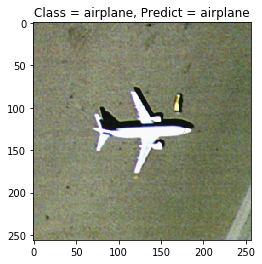

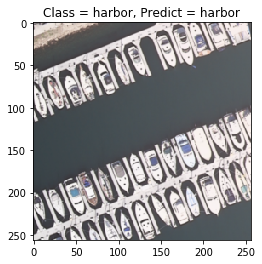

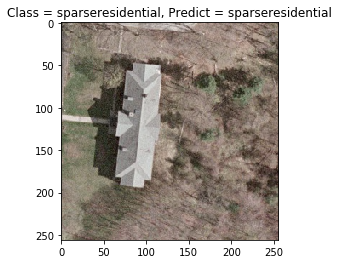

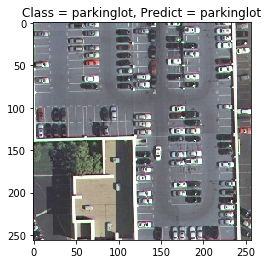

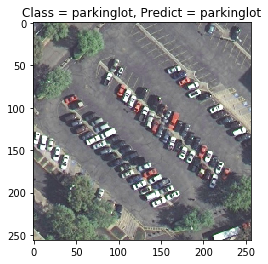

In [0]:
# Plot random some samples 

L = np.random.randint(0, num_classes * nb_samples_per_class, 5)

predictions = model.predict_classes(X[L], verbose=0)

for i in range(5) :
    show_sample(X[L[i]], Y[L[i]], prediction = predictions[i])

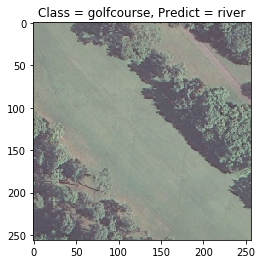

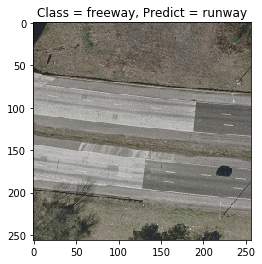

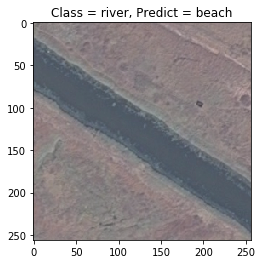

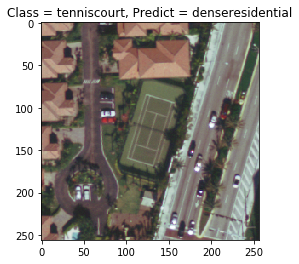

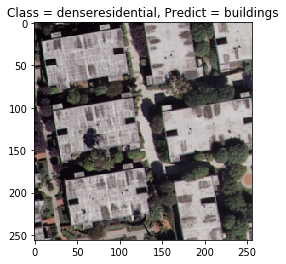

In [0]:
# Plot some wronly labeled samples (to try to understand why)

n = 30
i = 0

while i < 5:
  L = np.random.randint(0, num_classes * nb_samples_per_class, n)
  predictions = model.predict_classes(X[L], verbose=0)
  for j in range(n):
    if  Y[L[j]] != predictions[j]:
      show_sample(X[L[j]], Y[L[j]], prediction = predictions[j])
      i += 1

In [0]:
# Let's also try to predict multiple labels when images are misclassified 
# (to see if our prediction was close)

# The following function predicts multiple classes (one image at a time)

def pred_mult(x, y, model, k):
  a,b,c = x.shape
  pred = model.predict(x.reshape(1,a,b,c), verbose = 0)[0]
  n = len(pred)
  z = [(pred[i], i) for i in range(n)]
  z.sort()
  
  for i in range(k):
    print('Class {} : {} with probability {}'.format(i, class_name[z[n-1-i][1]], z[n-1-i][0]))
  show_sample(x,y)
  return

Class 0 : mediumresidential with probability 0.9886428713798523
Class 1 : denseresidential with probability 0.007865593768656254
Class 2 : buildings with probability 0.0013179490342736244


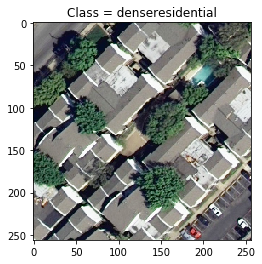

Class 0 : beach with probability 0.9856510758399963
Class 1 : river with probability 0.013831238262355328
Class 2 : storagetanks with probability 0.0002219527814304456


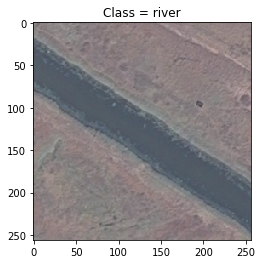

Class 0 : mediumresidential with probability 0.6548181176185608
Class 1 : intersection with probability 0.1795194298028946
Class 2 : denseresidential with probability 0.1439891755580902


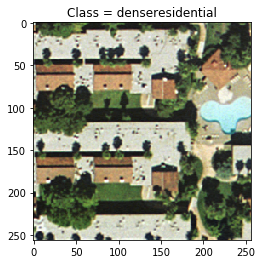

Class 0 : mediumresidential with probability 0.60179603099823
Class 1 : denseresidential with probability 0.3628578186035156
Class 2 : tenniscourt with probability 0.021937834098935127


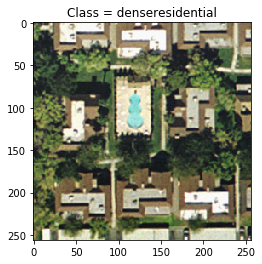

Class 0 : freeway with probability 0.7422347068786621
Class 1 : overpass with probability 0.2535715401172638
Class 2 : runway with probability 0.0039071859791874886


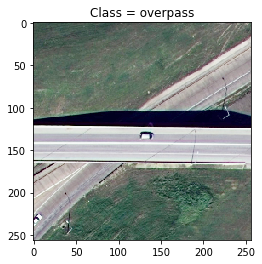

In [0]:
n = 30
i = 0

while i < 5:
  L = np.random.randint(0, num_classes * nb_samples_per_class, n)
  predictions = model.predict_classes(X[L], verbose=0)
  for j in range(n):
    if  Y[L[j]] != predictions[j]:
      pred_mult(X[L[j]], Y[L[j]], model, 3)
      i += 1

## Add more classes

Now that our network performs really well, let's try to expand the dataset with more classes !

I created 4 more classes, and picked images mostly from Google Earth, but also online so that all the images don't look alike too much. Then I preprocessed them so that they have same dimensions and characteristics as the other images. However, I couldn't set their resolution to be the same than the previous images (it's smaller).


In [0]:
# Upload dataset to ggdrive in a zip file (by hand), and unzip it

!unzip "/content/drive/My Drive/Colab Notebooks/COMS4995_Final_Project/Hand_dataset.zip"

In [0]:
# Add the new classes

class_name[21] = 'island'
class_name[22] = 'rocky_mountain'
class_name[23] = 'snowy_mountain'
class_name[24] = 'swamp'

num_classes = 25

In [56]:
class_name

{0: 'agricultural',
 1: 'airplane',
 2: 'baseballdiamond',
 3: 'beach',
 4: 'buildings',
 5: 'chaparral',
 6: 'denseresidential',
 7: 'forest',
 8: 'freeway',
 9: 'golfcourse',
 10: 'harbor',
 11: 'intersection',
 12: 'mediumresidential',
 13: 'mobilehomepark',
 14: 'overpass',
 15: 'parkinglot',
 16: 'river',
 17: 'runway',
 18: 'sparseresidential',
 19: 'storagetanks',
 20: 'tenniscourt',
 21: 'island',
 22: 'rocky_mountain',
 23: 'snowy_mountain',
 24: 'swamp'}

In [0]:
X_n = []
Y_n = []

for k in range(21, num_classes):
  X_n.append([np.array(Image.open(im).resize((img_width, img_height))) 
            for im in glob.glob('/content/Hand_dataset/' + class_name[k] + '/*.tif')])
  Y_n.append([np.ones(nb_samples_per_class) * k])
  
X_n = np.array(X_n).reshape(-1, img_width, img_height, 3)
Y_n = np.array(Y_n).reshape(-1)

X_new = np.concatenate((X, X_n))
Y_new = np.concatenate((Y, Y_n))

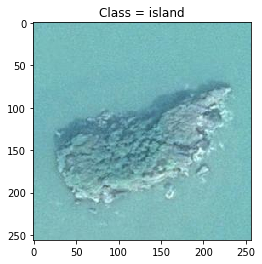

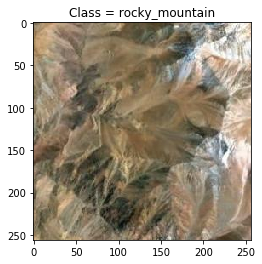

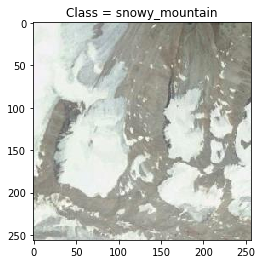

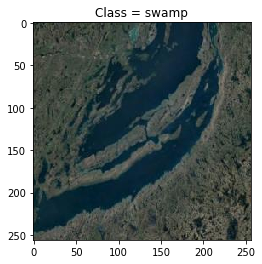

In [0]:
# Show an image of each new class

l = np.random.randint(0, nb_samples_per_class)
for i in range(21, num_classes):
  show_sample(X_new[i*nb_samples_per_class + l], Y_new[i*nb_samples_per_class + l])

## Use our model on the new dataset

Will adding 4 more classes make the accuracy fall ? Let's see !

In [0]:
kfold = StratifiedKFold(n_splits = 5, shuffle = True)
CV_scores = []

for train, test in kfold.split(X_new, Y_new):

  # Create the model
  model = Sequential()
  model.add(ResNet152(include_top = False, pooling = 'avg', weights = 'imagenet'))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  
  # We start by training the top of the model
  model.layers[0].trainable = False

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
  model.fit(X_new[train], Y_new[train], epochs = epochs_top, batch_size = batch_size_top, verbose = 1,
            validation_data = (X_new[test], Y_new[test]))
  loss, accuracy = model.evaluate(X_new[test], Y_new[test], verbose = 0)
  print("Training top layers. Accuracy : {} %. Loss : {}".format(accuracy * 100, loss))

  # Then we fine-tune by training the whole model
  model.layers[0].trainable = True

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['sparse_categorical_accuracy'])
  model.fit(X_new[train], Y_new[train], epochs = epochs_full, batch_size = batch_size_full, verbose = 1,
            validation_data = (X_new[test], Y_new[test]))
  loss, accuracy = model.evaluate(X_new[test], Y_new[test], verbose = 0)
  print("Training full model. Accuracy : {} %. Loss : {}".format(accuracy * 100, loss))
  
  CV_scores.append(accuracy * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(CV_scores), np.std(CV_scores)))

Train on 2000 samples, validate on 500 samples
Epoch 1/2
2000/2000 [==============================] - 25s 13ms/sample - loss: 1.4807 - sparse_categorical_accuracy: 0.6755 - val_loss: 0.9793 - val_sparse_categorical_accuracy: 0.7580
Epoch 2/2
2000/2000 [==============================] - 17s 8ms/sample - loss: 0.4241 - sparse_categorical_accuracy: 0.8715 - val_loss: 1.8729 - val_sparse_categorical_accuracy: 0.6300
Training top layers. Accuracy : 62.99999952316284 %. Loss : 1.8729432663917542
Train on 2000 samples, validate on 500 samples
Epoch 1/2
2000/2000 [==============================] - 82s 41ms/sample - loss: 0.2048 - sparse_categorical_accuracy: 0.9320 - val_loss: 0.2849 - val_sparse_categorical_accuracy: 0.9020
Epoch 2/2
2000/2000 [==============================] - 46s 23ms/sample - loss: 0.1237 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.1378 - val_sparse_categorical_accuracy: 0.9460
Training full model. Accuracy : 94.59999799728394 %. Loss : 0.13775510704517366
Train on

The accuracy is as good as before ! (even slightly better)

Class 0 : denseresidential with probability 0.810323178768158
Class 1 : mediumresidential with probability 0.15619632601737976
Class 2 : buildings with probability 0.02452961727976799


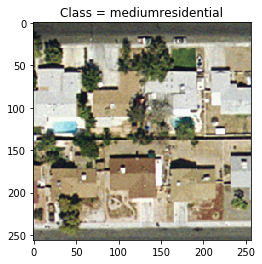

Class 0 : mediumresidential with probability 0.6165984272956848
Class 1 : denseresidential with probability 0.38105154037475586
Class 2 : buildings with probability 0.0015943333273753524


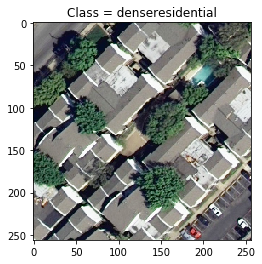

Class 0 : denseresidential with probability 0.4935590624809265
Class 1 : mediumresidential with probability 0.4317306876182556
Class 2 : sparseresidential with probability 0.05209970846772194


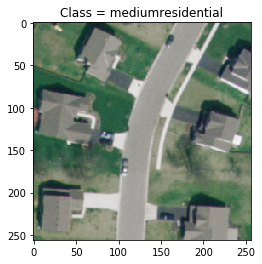

Class 0 : river with probability 0.3083444833755493
Class 1 : forest with probability 0.27250099182128906
Class 2 : baseballdiamond with probability 0.19146591424942017


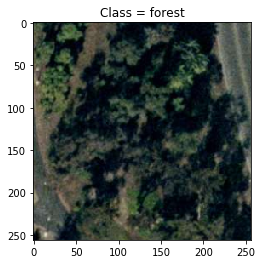

Class 0 : mediumresidential with probability 0.8368054628372192
Class 1 : denseresidential with probability 0.15139004588127136
Class 2 : buildings with probability 0.010587011463940144


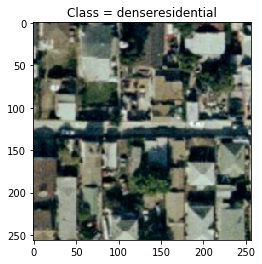

Class 0 : mediumresidential with probability 0.5295296311378479
Class 1 : intersection with probability 0.40953874588012695
Class 2 : denseresidential with probability 0.03550196439027786


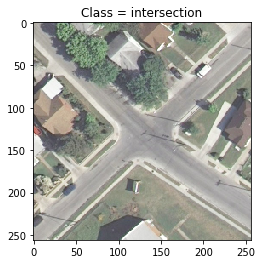

Class 0 : sparseresidential with probability 0.43521273136138916
Class 1 : storagetanks with probability 0.4043407738208771
Class 2 : buildings with probability 0.07892422378063202


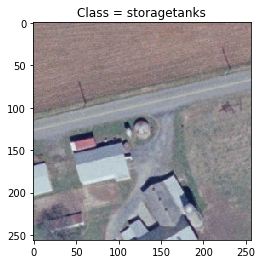

Class 0 : buildings with probability 0.5996761918067932
Class 1 : tenniscourt with probability 0.16573669016361237
Class 2 : storagetanks with probability 0.11043503880500793


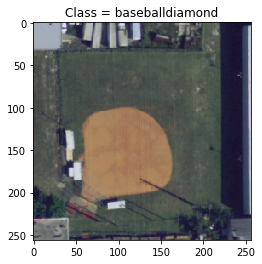

Class 0 : overpass with probability 0.7625173330307007
Class 1 : intersection with probability 0.20904363691806793
Class 2 : freeway with probability 0.02656884491443634


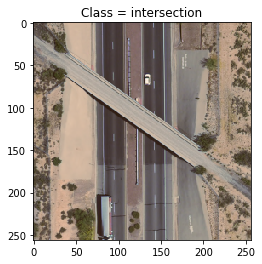

Class 0 : beach with probability 0.3927237391471863
Class 1 : golfcourse with probability 0.30096718668937683
Class 2 : island with probability 0.13437560200691223


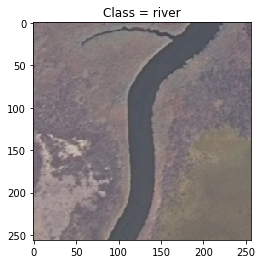

In [0]:
# Let's plot some wronly classified samples, with the multiple predictions functions

n = 30
i = 0

while i < 10:
  L = np.random.randint(0, num_classes * nb_samples_per_class, n)
  predictions = model.predict_classes(X_new[L], verbose=0)
  for j in range(n):
    if  Y_new[L[j]] != predictions[j]:
      pred_mult(X_new[L[j]], Y_new[L[j]], model, 3)
      i += 1

In [0]:
# Finally, let's look at the accuracies of each class

acc = [0 for _ in range(num_classes)]

pred = model.predict_classes(X_new[test], verbose = 0)

n = len(test)
for k in range(n):
  if pred[k] == Y_new[test[k]]:
    acc[pred[k]] += 1

A = [acc[k] * (num_classes/n) * 100 for k in range(num_classes)]

for k in range(num_classes):
  print("Accuracy of class {} : {} %".format(class_name[k], A[k]))

Accuracy of class agricultural : 95.0 %
Accuracy of class airplane : 100.0 %
Accuracy of class baseballdiamond : 95.0 %
Accuracy of class beach : 100.0 %
Accuracy of class buildings : 90.0 %
Accuracy of class chaparral : 100.0 %
Accuracy of class denseresidential : 85.00000000000001 %
Accuracy of class forest : 95.0 %
Accuracy of class freeway : 95.0 %
Accuracy of class golfcourse : 100.0 %
Accuracy of class harbor : 100.0 %
Accuracy of class intersection : 95.0 %
Accuracy of class mediumresidential : 85.00000000000001 %
Accuracy of class mobilehomepark : 95.0 %
Accuracy of class overpass : 100.0 %
Accuracy of class parkinglot : 100.0 %
Accuracy of class river : 90.0 %
Accuracy of class runway : 100.0 %
Accuracy of class sparseresidential : 80.0 %
Accuracy of class storagetanks : 90.0 %
Accuracy of class tenniscourt : 100.0 %
Accuracy of class island : 100.0 %
Accuracy of class rocky_mountain : 100.0 %
Accuracy of class snowy_mountain : 95.0 %
Accuracy of class swamp : 95.0 %


As we can see, the hardest classes for our model are the residential ones : denseresidensial, mediumresidential and sparseresidential. The reason is that they really look alike. A further work could be to develop a model or a technique that would permit to increase the accuracy on these classes (and more generally, that would be able to separate classes that are very similar).